In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

In [ ]:
train=pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train.drop(labels='Id',axis=1,inplace=True)

In [ ]:
# missing values count
N_columns=[]
for i in train.columns:
    x=np.round(train[i].isnull().mean()*100,2)
    if x>50:
      print(i+' : ' + str(x)+ ' %')
    elif x>0:
      N_columns.append(i)

train.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'],inplace=True) # Dropping columns which have missing values more than 80%
#print(N_columns)
len(N_columns)

Alley : 93.77 %
PoolQC : 99.52 %
Fence : 80.75 %
MiscFeature : 96.3 %


15

In [ ]:
#fill NAN values
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())
train['MasVnrType']=train['MasVnrType'].fillna('None')
train['MasVnrArea']=train['MasVnrArea'].fillna(train['MasVnrArea'].mean())
train['BsmtQual']=train['BsmtQual'].fillna(train['BsmtQual'].mode().values[0])
train['BsmtCond']=train['BsmtCond'].fillna(train['BsmtCond'].mode().values[0])
train['BsmtExposure']=train['BsmtExposure'].fillna(train['BsmtExposure'].mode().values[0])
train['BsmtFinType1']=train['BsmtFinType1'].fillna(train['BsmtFinType1'].mode().values[0])
train['BsmtFinType2']=train['BsmtFinType2'].fillna(train['BsmtFinType2'].mode().values[0])
train['Electrical']=train['Electrical'].fillna(train['Electrical'].mode().values[0])
train['FireplaceQu']=train['FireplaceQu'].fillna('None')
train['GarageType']=train['GarageType'].fillna(train['GarageType'].mode().values[0])
train['GarageFinish']=train['GarageFinish'].fillna(train['GarageFinish'].mode().values[0])
train['GarageQual']=train['GarageQual'].fillna(train['GarageQual'].mode().values[0])
train['GarageCond']=train['GarageCond'].fillna(train['GarageCond'].mode().values[0])

In [ ]:
# Handling Temporal train
year=train[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']]
year.corr() # Checking for time based train correlation
#Feature Engineering
train['YearBuilt_age']=train['YrSold']-train['YearBuilt'] #converting Year time interms of age of built train
train['YearRemodAdd_age']=train['YrSold']-train['YearRemodAdd'] #converting Remodling Year time interms of age of remodelling train
train.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt'],inplace=True)   #Dropping GarageYrBlt as highly correlated with  Year Built and other columns as converted to int variables

In [ ]:
#Classifying the features based train type
Numerical=[]
Categorical=[]
for i in train.columns:
  # if i not in year:
    if train[i].dtype=='O':
      Categorical.append(i)
    elif i =='YrSold':
      Categorical.append(i)
    elif train[i].dtype!='O':
      Numerical.append(i)

print(Numerical)
print('\n')
print(Categorical)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice', 'YearBuilt_age', 'YearRemodAdd_age']


['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedD

#Test Data

In [ ]:
test=pd.read_csv('test.csv')
test_Id=test['Id']
test.drop(labels='Id',axis=1,inplace=True)
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
# missing values count in Test train
N_columns_test=[]
for i in test.columns:
    x=np.round(test[i].isnull().mean()*100,2)
    if x>50:
      print(i+' : ' + str(x)+ ' %')
    elif x>0:
      N_columns_test.append(i)

test.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'],inplace=True) # Dropping columns which have missing values more than 80%
len(N_columns_test)

Alley : 92.67 %
FireplaceQu : 50.03 %
PoolQC : 99.79 %
Fence : 80.12 %
MiscFeature : 96.5 %


28

In [ ]:
test['MSZoning']=test['MSZoning'].fillna(train['MSZoning'].mode().values[0])
test['LotFrontage']=test['LotFrontage'].fillna(train['LotFrontage'].mean())
test['Utilities']=test['Utilities'].fillna(train['Utilities'].mode().values[0])
test['Exterior1st']=test['Exterior1st'].fillna(train['Exterior1st'].mode().values[0])
test['Exterior2nd']=test['Exterior2nd'].fillna(train['Exterior2nd'].mode().values[0])
test['MasVnrType']=test['MasVnrType'].fillna('None')
test['MasVnrArea']=test['MasVnrArea'].fillna(train['MasVnrArea'].mean())
test['BsmtQual']=test['BsmtQual'].fillna(train['BsmtQual'].mode().values[0])
test['BsmtCond']=test['BsmtCond'].fillna(train['BsmtCond'].mode().values[0])
test['BsmtExposure']=test['BsmtExposure'].fillna(train['BsmtExposure'].mode().values[0])
test['BsmtFinType1']=test['BsmtFinType1'].fillna(train['BsmtFinType1'].mode().values[0])
test['BsmtFinType2']=test['BsmtFinType2'].fillna(train['BsmtFinType2'].mode().values[0])
test['Electrical']=test['Electrical'].fillna(train['Electrical'].mode().values[0])
test['FireplaceQu']=test['FireplaceQu'].fillna('None')
test['GarageType']=test['GarageType'].fillna(train['GarageType'].mode().values[0])
test['GarageFinish']=test['GarageFinish'].fillna(train['GarageFinish'].mode().values[0])
test['GarageQual']=test['GarageQual'].fillna(train['GarageQual'].mode().values[0])
test['GarageCond']=test['GarageCond'].fillna(train['GarageCond'].mode().values[0])
test['BsmtFinSF1']=test['BsmtFinSF1'].fillna(train['BsmtFinSF1'].mean())
test['BsmtFinSF2']=test['BsmtFinSF2'].fillna(train['BsmtFinSF2'].mean())
test['BsmtUnfSF']=test['BsmtUnfSF'].fillna(train['BsmtUnfSF'].mean())
test['TotalBsmtSF']=test['TotalBsmtSF'].fillna(train['TotalBsmtSF'].mean())
test['BsmtFullBath']=test['BsmtFullBath'].fillna(train['BsmtFullBath'].mean())
test['BsmtHalfBath']=test['BsmtHalfBath'].fillna(train['BsmtHalfBath'].mean())
test['KitchenQual']=test['KitchenQual'].fillna(train['KitchenQual'].mode().values[0])
test['Functional']=test['Functional'].fillna(train['Functional'].mode().values[0])
test['SaleType']=test['SaleType'].fillna(train['SaleType'].mode().values[0])
test['GarageCars']=test['GarageCars'].fillna(train['GarageCars'].mean())
test['GarageArea']=test['GarageArea'].fillna(train['GarageArea'].mean())

In [ ]:
# Handling Temporal Data
year=test[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']]
year.corr() # Checking for time based data correlation
#Feature Engineering
test['YearBuilt_age']=test['YrSold']-test['YearBuilt'] #converting Year time interms of age of built data
test['YearRemodAdd_age']=test['YrSold']-test['YearRemodAdd'] #converting Remodling Year time interms of age of remodelling data
test.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt'],inplace=True)   #Dropping GarageYrBlt as highly correlated with  Year Built and other columns as converted to int variables

In [ ]:
#Classifying the features based data type
Numerical_t=[]
Categorical_t=[]
for i in test.columns:
  # if i not in year:
    if test[i].dtype=='O':
      Categorical_t.append(i)
    elif i =='YrSold':
      Categorical_t.append(i)
    elif test[i].dtype!='O':
      Numerical_t.append(i)

print(Numerical_t)
print('\n')
print(Categorical_t)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YearBuilt_age', 'YearRemodAdd_age']


['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'YrSol

#Categorical Data

In [ ]:
Categorical_total=pd.concat([train[Categorical],test[Categorical_t]])

In [ ]:
Categorical_encode=Categorical_total[Categorical].apply(LabelEncoder().fit_transform)
Categorical_encode

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,YrSold,SaleType,SaleCondition
0,3,1,3,3,0,4,0,5,2,2,0,5,1,1,12,13,1,2,4,2,2,3,3,2,5,1,0,1,4,2,6,3,1,1,4,4,2,2,8,4
1,3,1,3,3,0,2,0,24,1,2,0,2,1,1,8,8,2,3,4,1,2,3,1,0,5,1,0,1,4,3,6,5,1,1,4,4,2,1,8,4
2,3,1,0,3,0,4,0,5,2,2,0,5,1,1,12,13,1,2,4,2,2,3,2,2,5,1,0,1,4,2,6,5,1,1,4,4,2,2,8,4
3,3,1,0,3,0,0,0,6,2,2,0,5,1,1,13,15,2,3,4,0,3,1,3,0,5,1,2,1,4,2,6,2,5,2,4,4,2,0,8,0
4,3,1,0,3,0,2,0,15,2,2,0,5,1,1,12,13,1,2,4,2,2,3,0,2,5,1,0,1,4,2,6,5,1,1,4,4,2,2,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1,3,3,0,4,0,10,2,2,3,5,1,1,5,5,2,3,4,1,3,3,3,5,5,1,2,1,4,3,6,3,1,2,4,4,2,0,8,4
1455,4,1,3,3,0,4,0,10,2,2,4,5,1,1,5,5,2,3,4,1,3,3,3,4,5,1,4,1,4,3,6,3,4,2,4,4,2,0,8,0
1456,3,1,3,3,0,4,0,11,2,2,0,2,1,1,12,13,2,3,4,1,3,3,3,0,5,1,0,1,4,3,6,5,5,2,4,4,2,0,8,0
1457,3,1,3,3,0,4,0,11,2,2,0,6,1,1,6,15,2,3,4,2,2,3,0,2,5,1,4,1,4,3,6,3,1,2,4,4,2,0,8,4


In [ ]:
X=pd.concat([train[Numerical],Categorical_encode.iloc[:1460,:]],axis=1)
X.shape

(1460, 75)

In [ ]:
X=X.drop(columns='SalePrice')
Y=train['SalePrice']

In [ ]:
XGB=XGBRegressor()
XGB.fit(X,Y)

[11:33:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# Define the grid of hyperparameters to search
grid_param =   {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.01,0.02,0.03], #so called `eta` value
              'max_depth': [1,3,5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7,0.8,0.9],
              'n_estimators': [500,1000]}

In [ ]:
grid_search = GridSearchCV(estimator=XGB,   param_grid=grid_param,    cv=5,       n_jobs =-1)

In [ ]:
grid_search.fit(X,Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [1, 3, 5], 'min_child_weight': [4],
                      

In [ ]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': -1, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.8}


In [ ]:
XGB=XGBRegressor(colsample_bytree= 0.8, learning_rate= 0.03, max_depth= 5, min_child_weight= 4, n_estimators= 1000, nthread= -1, objective= 'reg:linear', silent=1, subsample= 0.8)
XGB.fit(X,Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=1000,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.8, verbosity=1)

In [ ]:
train_predict=XGB.predict(X)

In [ ]:
mean_squared_error(Y,train_predict)

11722877.423482962

In [ ]:
np.sqrt(mean_squared_error(np.log(Y),np.log(train_predict)))#0.04863   0.0240

0.024082528924253388

In [ ]:
X_test=pd.concat([test[Numerical_t],Categorical_encode.iloc[1460:,:]],axis=1)
X_test.shape

(1459, 74)

In [ ]:
test_predict=XGB.predict(X_test)
test_predict

array([128724.914, 156479.11 , 182501.75 , ..., 168775.1  , 117783.58 ,
       228916.6  ], dtype=float32)

In [ ]:
Test_SalePrice=pd.DataFrame()
Test_SalePrice['Id']=test_Id
Test_SalePrice['SalePrice']=test_predict

In [ ]:
Test_SalePrice

,Id,SalePrice
0,1461,128724.914062
1,1462,156479.109375
2,1463,182501.750000
3,1464,194629.093750
4,1465,179348.531250
...,...,...
1454,2915,76865.695312
1455,2916,80700.429688
1456,2917,168775.093750
1457,2918,117783.578125


In [ ]:
Test_SalePrice.to_csv('SalePrice_XGB.csv',index=False)

In [ ]:
feature_importance = XGB.feature_importances_

In [ ]:
feature_importance

array([0.00330937, 0.00292286, 0.00486893, 0.29876712, 0.00410623,
       0.00193944, 0.01183174, 0.00128984, 0.00128539, 0.0132041 ,
       0.01035542, 0.01390865, 0.0006876 , 0.03595373, 0.00563333,
       0.00096669, 0.057089  , 0.00228302, 0.00523502, 0.00908591,
       0.00919075, 0.01075693, 0.15627289, 0.00703626, 0.00174789,
       0.00292842, 0.00077859, 0.00080435, 0.00170577, 0.00372063,
       0.00066294, 0.00165585, 0.00735485, 0.00786668, 0.00560262,
       0.        , 0.00230569, 0.00625488, 0.        , 0.00082489,
       0.00301551, 0.00638197, 0.00161605, 0.00069155, 0.01221203,
       0.00099307, 0.00078203, 0.0019763 , 0.00155537, 0.00146131,
       0.00157557, 0.11565984, 0.00204513, 0.00086184, 0.05372071,
       0.00143323, 0.00421551, 0.00522814, 0.00123363, 0.00103109,
       0.0012203 , 0.01582914, 0.00080181, 0.02340928, 0.00293299,
       0.00105324, 0.00645283, 0.00861241, 0.00076332, 0.0004695 ,
       0.00196492, 0.00082735, 0.00195668, 0.003822  ], dtype=

In [ ]:
# summarize feature importance
for i,v in enumerate(feature_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: 0.00331
Feature: 1, Score: 0.00292
Feature: 2, Score: 0.00487
Feature: 3, Score: 0.29877
Feature: 4, Score: 0.00411
Feature: 5, Score: 0.00194
Feature: 6, Score: 0.01183
Feature: 7, Score: 0.00129
Feature: 8, Score: 0.00129
Feature: 9, Score: 0.01320
Feature: 10, Score: 0.01036
Feature: 11, Score: 0.01391
Feature: 12, Score: 0.00069
Feature: 13, Score: 0.03595
Feature: 14, Score: 0.00563
Feature: 15, Score: 0.00097
Feature: 16, Score: 0.05709
Feature: 17, Score: 0.00228
Feature: 18, Score: 0.00524
Feature: 19, Score: 0.00909
Feature: 20, Score: 0.00919
Feature: 21, Score: 0.01076
Feature: 22, Score: 0.15627
Feature: 23, Score: 0.00704
Feature: 24, Score: 0.00175
Feature: 25, Score: 0.00293
Feature: 26, Score: 0.00078
Feature: 27, Score: 0.00080
Feature: 28, Score: 0.00171
Feature: 29, Score: 0.00372
Feature: 30, Score: 0.00066
Feature: 31, Score: 0.00166
Feature: 32, Score: 0.00735
Feature: 33, Score: 0.00787
Feature: 34, Score: 0.00560
Feature: 35, Score: 0.00000
Fe

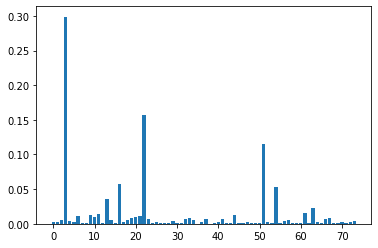

In [ ]:
# plot feature importance
plt.bar([x for x in range(len(feature_importance))], feature_importance)
plt.show()